## 3. Structure discovery for the Lorenz-96 problem

In this notebook, we will show how we can estimate the conditional independence structure of a random variable $\mathsf{X} \in \mathbb{R}^{N_x}$ with density $\pi$ based on i.i.d. samples $\{\boldsymbol{x}^i\}, \; i = 1, \ldots, N_e$ from $\pi$.

Reference: 

[1] Lorenz, E.N., 1996, September. Predictability: A problem partly solved. In Proc. Seminar on predictability (Vol. 1, No. 1).

[2] Baptista, R., Zahm, O., & Marzouk, Y. (2020). An adaptive transport framework for joint and conditional density estimation. arXiv preprint arXiv:2009.10303.

[3] Baptista, R., Marzouk, Y., Morrison, R.E. and Zahm, O., 2021. Learning non-Gaussian graphical models via Hessian scores and triangular transport. arXiv preprint arXiv:2101.03093.


In [51]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq
using ProgressMeter

Load some packages to make nice figures

In [3]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-96 model [1] is a famous problem used in data assimilation and weather prediction. It was derived from first principles as a one-dimensional model for the response of the mid-latitude atmosphere to forcing input. For certain forcing input, it can exhibit a chaotic behavior: sensitivity to initial conditions, strong mixing. In this notebook, we consider the fifteen-dimensional version of the Lorenz-96 model.  The state $\boldsymbol{x} = (x_1, \ldots, x_{15})$ at time $t$ is governed by the following set of ordinary differential equations:  

\begin{equation}
    \frac{\mathrm{d}x_i}{\mathrm{d}t} = (x_{i+1} - x_{i-2}) x_{i-1} -x_i + F,
\end{equation}
where it is assumed that $x_{-1} = x_{n − 1} , x_0 = x_{n}$ and $x_{n+1} = x_1$, setting the forcing input $F=8.0$ leads to chaos.

We integrate the Lorenz-96 problem with our favorite ODE library: OrdinaryDiffEq.jl.

In [4]:
function lorenz96!(du,u,p,t)
    F = 8.0
    n = size(u,1)
    du[1] = (u[2]-u[end-1])*u[end] - u[1] + F
    du[2] = (u[3]-u[end])*u[1] - u[2] + F
    du[end] = (u[1] - u[end-2])*u[end-1] - u[end] + F

    @inbounds for i=3:n-1
        du[i] = (u[i+1] - u[i-2])*u[i-1] - u[i] + F
    end
    return du
end

lorenz96! (generic function with 1 method)

In [103]:
# Define the distribution for initial condition
Nx = 15
# Number of runs
Ne = 500
πx0 = MvNormal(zeros(Nx), ones(Nx))
# Zero vector of the size of the state
x0 = rand(πx0)

# Time stepp
tspan = (0.0, 500.0)
prob = ODEProblem(lorenz96!,x0, tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 500.0)
u0: [0.22441352468464734, -0.5358920970483066, 0.3327776963920296, -0.392102299724594, 1.1468786989302455, 0.6964222127949522, -0.7081181090863459, 0.2543632206563426, -0.4005028463110368, -0.003911075628317382, -0.7068466465049782, -0.7844602152911724, -2.1892113051519964, -0.7579373117902316, -1.0484967129683136]

Create cache to store the different final solutions

In [104]:
X = zeros(Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`

In [105]:
@inbounds for i=1:Ne
    prob = remake(prob; u0 = rand(πx0))
    sol = solve(prob, Tsit5(), dt = 0.01, adaptive = false, dense = false, saveat = tspan[end], save_start = false)
    X[:,i] = deepcopy(sol.u[1])
end

We can use the adaptive transport map procedure to estimate the underlying distribution for the state $\mathsf{X}$.

In [106]:
m = 60
S = HermiteMap(m, X; diag = true);

The optimization procedure takes about 5 minutes with $N_e = 500$ samples

In [107]:
optimize(S, X, "kfold"; withqr = true, verbose = true, conditioner = true)

1 terms - Training error: 1.408636068630604, Validation error: 1.455148391500947
1 terms - Training error: 1.4080830092326198, Validation error: 1.4583051354920433
2 terms - Training error: 1.407989423410087, Validation error: 1.45802459157214
3 terms - Training error: 1.4056909024454485, Validation error: 1.4550443897652356
4 terms - Training error: 1.4055243440612302, Validation error: 1.457954752848701
5 terms - Training error: 1.4055176980221404, Validation error: 1.4578616519770617
6 terms - Training error: 1.3982756424420881, Validation error: 1.4396914602178985
7 terms - Training error: 1.392534853025487, Validation error: 1.440917720685203
8 terms - Training error: 1.3913570421355492, Validation error: 1.4407764788114723
9 terms - Training error: 1.3839279887061056, Validation error: 1.438373931553408
10 terms - Training error: 1.3830567148737662, Validation error: 1.437928694389438
11 terms - Training error: 1.3732402695240908, Validation error: 1.456708674481984
12 terms - Tr

12 terms - Training error: 1.3805394737365455, Validation error: 1.4182811821274532
13 terms - Training error: 1.380351504727234, Validation error: 1.4172391794072223
14 terms - Training error: 1.3802876278439173, Validation error: 1.4169204620122382
15 terms - Training error: 1.3799669905845149, Validation error: 1.4192097194487727
16 terms - Training error: 1.3794109326041435, Validation error: 1.4207895967967235
17 terms - Training error: 1.3792385527504456, Validation error: 1.4225659750042183
18 terms - Training error: 1.37793445633792, Validation error: 1.425876937614904
19 terms - Training error: 1.377889500426317, Validation error: 1.4248363617549937
20 terms - Training error: 1.3774249272249084, Validation error: 1.4264080553349572
21 terms - Training error: 1.3769548827062676, Validation error: 1.422894105219267
22 terms - Training error: 1.3769548563167895, Validation error: 1.422902430653112
23 terms - Training error: 1.3764739306656277, Validation error: 1.4203680322547432

Progress:   7%|██▊                                      |  ETA: 0:01:00

4 terms - Training error: 1.4151980983417043
5 terms - Training error: 1.4151567528403612
6 terms - Training error: 1.40548305364426
7 terms - Training error: 1.4010593848901238
8 terms - Training error: 1.3999708808759348
9 terms - Training error: 1.3931703821766843
10 terms - Training error: 1.3922381875858159
1 terms - Training error: 1.4135932958157276, Validation error: 1.4353194827604552
1 terms - Training error: 1.4106951129051593, Validation error: 1.4601601478989223
2 terms - Training error: 1.3997688707159925, Validation error: 1.458105939285068
3 terms - Training error: 1.3949173768315677, Validation error: 1.4449118600908286
4 terms - Training error: 1.3909194953866542, Validation error: 1.4314572686892924
5 terms - Training error: 1.3903204825901498, Validation error: 1.4263000188301638
6 terms - Training error: 1.3891409830278922, Validation error: 1.432955834283088
7 terms - Training error: 1.388476445907593, Validation error: 1.4310296122163897
8 terms - Training error:

7 terms - Training error: 1.3678070377007017, Validation error: 1.450696657228963
8 terms - Training error: 1.3633610689988305, Validation error: 1.4400519737027382
9 terms - Training error: 1.3390630347854053, Validation error: 1.423746784719218
10 terms - Training error: 1.3284597249256351, Validation error: 1.4027251971366868
11 terms - Training error: 1.321093763442654, Validation error: 1.385214790067646
12 terms - Training error: 1.3174770009624757, Validation error: 1.4026156521010535
13 terms - Training error: 1.311554763861453, Validation error: 1.4040001173314205
14 terms - Training error: 1.311266260685611, Validation error: 1.4062427177354515
15 terms - Training error: 1.3106063562984887, Validation error: 1.4022069316152295
16 terms - Training error: 1.3094679432533232, Validation error: 1.4150151831055573
17 terms - Training error: 1.3052017865373233, Validation error: 1.403865426878124
18 terms - Training error: 1.3033128724848257, Validation error: 1.3930536838651113
19

Progress:  13%|█████▌                                   |  ETA: 0:00:46

20 terms - Training error: 1.31358575155059
1 terms - Training error: 1.4055642527194823, Validation error: 1.4674356551454337
1 terms - Training error: 1.4039512283345743, Validation error: 1.4711458496723875
2 terms - Training error: 1.3962665916896055, Validation error: 1.467750073103692
3 terms - Training error: 1.394582747877212, Validation error: 1.4631052169507888
4 terms - Training error: 1.385125899762417, Validation error: 1.463501734945535
5 terms - Training error: 1.3717104201257768, Validation error: 1.473190127352917
6 terms - Training error: 1.3658499349923199, Validation error: 1.4400569547270736
7 terms - Training error: 1.3095257969828569, Validation error: 1.386040902118303
8 terms - Training error: 1.3077878692692968, Validation error: 1.381813496690167
9 terms - Training error: 1.2968483265421056, Validation error: 1.3920601607822414
10 terms - Training error: 1.2924445391682873, Validation error: 1.3991031842937562
11 terms - Training error: 1.2872496151409316, Va

13 terms - Training error: 1.2993021204230146, Validation error: 1.3237417151324045
14 terms - Training error: 1.2974536227029545, Validation error: 1.3218744049086897
15 terms - Training error: 1.2957062587835002, Validation error: 1.3276480359451193
16 terms - Training error: 1.291823562554702, Validation error: 1.334031865064154
17 terms - Training error: 1.288884855402122, Validation error: 1.3423374995739408
18 terms - Training error: 1.2869231828124814, Validation error: 1.349333147914673
19 terms - Training error: 1.2791814178952248, Validation error: 1.3326506965256033
20 terms - Training error: 1.2626360556887772, Validation error: 1.2884200105493038
21 terms - Training error: 1.2608706715357805, Validation error: 1.2883693317113711
22 terms - Training error: 1.2599583139291726, Validation error: 1.2845733315256482
23 terms - Training error: 1.2596282195500743, Validation error: 1.28201892263311
1 terms - Training error: 1.4179385332046726
1 terms - Training error: 1.417217578

Progress:  20%|████████▎                                |  ETA: 0:00:41

22 terms - Training error: 1.2328526315853996
23 terms - Training error: 1.2290735239494543
1 terms - Training error: 1.4144946280765758, Validation error: 1.4317141537170615
1 terms - Training error: 1.4109062616291295, Validation error: 1.440655850737725
2 terms - Training error: 1.3875329923180253, Validation error: 1.387383124973996
3 terms - Training error: 1.3823313642482074, Validation error: 1.369324996700931
4 terms - Training error: 1.3792133776489721, Validation error: 1.36816461545921
5 terms - Training error: 1.3728970860791332, Validation error: 1.3674709317851712
6 terms - Training error: 1.3668828151747228, Validation error: 1.357962502756458
7 terms - Training error: 1.3636610167255931, Validation error: 1.3602341584483313
8 terms - Training error: 1.3631961064039004, Validation error: 1.3554139051043268
9 terms - Training error: 1.3036673281022333, Validation error: 1.2579688545067258
10 terms - Training error: 1.302064417124823, Validation error: 1.2541919588445074
1

18 terms - Training error: 1.2602302809097057, Validation error: 1.4193886499930435
19 terms - Training error: 1.256407771727571, Validation error: 1.4295488203603783
20 terms - Training error: 1.2347341232196374, Validation error: 1.3872642349343285
21 terms - Training error: 1.2186014449606175, Validation error: 1.4524625361253796
22 terms - Training error: 1.2015918039728415, Validation error: 1.4813321202207994
23 terms - Training error: 1.19706456771559, Validation error: 1.4492707578103938
1 terms - Training error: 1.4179385332046728
1 terms - Training error: 1.4164217537162405
2 terms - Training error: 1.3868122577034114
3 terms - Training error: 1.3787280470202727
4 terms - Training error: 1.376008105844423
5 terms - Training error: 1.3708592931488839
6 terms - Training error: 1.3641080677120117
7 terms - Training error: 1.3618123702396259
8 terms - Training error: 1.3601066185909918
9 terms - Training error: 1.2932492296969866
10 terms - Training error: 1.291234026995159
11 te

Progress:  27%|██████████▉                              |  ETA: 0:00:35

20 terms - Training error: 1.2480153086329664
21 terms - Training error: 1.2477752404909601
1 terms - Training error: 1.4237683117534297, Validation error: 1.3946194190096446
1 terms - Training error: 1.422822440780394, Validation error: 1.395940149994559
2 terms - Training error: 1.3638362363120047, Validation error: 1.3571686163172996
3 terms - Training error: 1.3527491728694077, Validation error: 1.3409447016258604
4 terms - Training error: 1.3482866396511344, Validation error: 1.3466718478924795
5 terms - Training error: 1.3396997805045308, Validation error: 1.3321848421536302
6 terms - Training error: 1.3335344193847682, Validation error: 1.3137776353456532
7 terms - Training error: 1.3289865478950527, Validation error: 1.3152297299445082
8 terms - Training error: 1.3284166538158084, Validation error: 1.314061497063322
9 terms - Training error: 1.3255517743509524, Validation error: 1.32422667729411
10 terms - Training error: 1.3237750290581518, Validation error: 1.3246278568470857

15 terms - Training error: 1.3188148941076916, Validation error: 1.3288790888176314
16 terms - Training error: 1.31708772170293, Validation error: 1.3252984196666124
17 terms - Training error: 1.3103877384497853, Validation error: 1.3241257734039487
18 terms - Training error: 1.307194772693168, Validation error: 1.32526061739502
19 terms - Training error: 1.3066865674659713, Validation error: 1.326731967181129
20 terms - Training error: 1.3061187724897187, Validation error: 1.3250898176041117
21 terms - Training error: 1.2838861130894503, Validation error: 1.3163256338933855
22 terms - Training error: 1.2835074213991, Validation error: 1.3205319436303111
23 terms - Training error: 1.2802172194574917, Validation error: 1.3204628083475063
1 terms - Training error: 1.417938533204673
1 terms - Training error: 1.4173923235605763
2 terms - Training error: 1.362328861738606
3 terms - Training error: 1.3502289750406704
4 terms - Training error: 1.3404466072496388
5 terms - Training error: 1.33

Progress:  33%|█████████████▋                           |  ETA: 0:00:30

23 terms - Training error: 1.286104160417118
24 terms - Training error: 1.28374967937697
1 terms - Training error: 1.4305432855925617, Validation error: 1.3675195236531144
1 terms - Training error: 1.4283154506958031, Validation error: 1.3746598675811506
2 terms - Training error: 1.3904144437178478, Validation error: 1.299364645964217
3 terms - Training error: 1.3837001327464062, Validation error: 1.2730322404222505
4 terms - Training error: 1.3793685550692065, Validation error: 1.276678011454025
5 terms - Training error: 1.3704028549853235, Validation error: 1.2882075013993657
6 terms - Training error: 1.3165081054207426, Validation error: 1.2762697423073441
7 terms - Training error: 1.3099745812040002, Validation error: 1.2601206319744247
8 terms - Training error: 1.3091735558657807, Validation error: 1.2562095701833043
9 terms - Training error: 1.307011852739135, Validation error: 1.2597474301243305
10 terms - Training error: 1.3061573521440564, Validation error: 1.2626702230299744


16 terms - Training error: 1.2919552397090563, Validation error: 1.2722478358895573
17 terms - Training error: 1.2889157639545008, Validation error: 1.2770876110428022
18 terms - Training error: 1.2883199830475618, Validation error: 1.2780682050745171
19 terms - Training error: 1.2871477130407216, Validation error: 1.2862295536909405
20 terms - Training error: 1.284608046736183, Validation error: 1.2789852588740103
21 terms - Training error: 1.2835146109361772, Validation error: 1.2776447600057586
22 terms - Training error: 1.2811109320412597, Validation error: 1.2726042411775387
23 terms - Training error: 1.2802254724378113, Validation error: 1.2751040019780047
1 terms - Training error: 1.4179385332046726
1 terms - Training error: 1.4160442335828936
2 terms - Training error: 1.371625997424083
3 terms - Training error: 1.3605855360535268
4 terms - Training error: 1.3597291758228314
5 terms - Training error: 1.356088335822194
6 terms - Training error: 1.3434431205215351
7 terms - Traini

Progress:  40%|████████████████▍                        |  ETA: 0:00:25

22 terms - Training error: 1.261377978652427
23 terms - Training error: 1.2580625478342757
1 terms - Training error: 1.4207931764406534, Validation error: 1.4065199602607477
1 terms - Training error: 1.418904323586292, Validation error: 1.4096750446191593
2 terms - Training error: 1.3293414985039937, Validation error: 1.3382877465287324
3 terms - Training error: 1.3110357482955366, Validation error: 1.33819831575601
4 terms - Training error: 1.2996445600992839, Validation error: 1.342209434667204
5 terms - Training error: 1.2978510980499847, Validation error: 1.338241957876744
6 terms - Training error: 1.2932381236403712, Validation error: 1.341580363280421
7 terms - Training error: 1.2914701855619395, Validation error: 1.339413697375983
8 terms - Training error: 1.2888791699265352, Validation error: 1.333438826219235
9 terms - Training error: 1.283147356929186, Validation error: 1.3426049133009552
10 terms - Training error: 1.281844102726492, Validation error: 1.3375439978377361
11 te

8 terms - Training error: 1.293697597732708, Validation error: 1.3381405040630197
9 terms - Training error: 1.291924126821052, Validation error: 1.3352305318943678
10 terms - Training error: 1.2889573137496475, Validation error: 1.3248461081310041
11 terms - Training error: 1.287027085602837, Validation error: 1.3184608398184532
12 terms - Training error: 1.2824193682677443, Validation error: 1.326949890661913
13 terms - Training error: 1.2798047843143083, Validation error: 1.3212255738075467
14 terms - Training error: 1.278794743136368, Validation error: 1.325115576111896
15 terms - Training error: 1.2777019042467153, Validation error: 1.3278922173607846
16 terms - Training error: 1.2774039867056124, Validation error: 1.330821239496906
17 terms - Training error: 1.2753603978623869, Validation error: 1.3366463244163107
18 terms - Training error: 1.2752280707882988, Validation error: 1.337834045421961
19 terms - Training error: 1.2738691701137876, Validation error: 1.3272270044776728
20

Progress:  47%|███████████████████▏                     |  ETA: 0:00:21

24 terms - Training error: 1.2465935775043118
1 terms - Training error: 1.4228914818802685, Validation error: 1.3981267385022857
1 terms - Training error: 1.4216674257246058, Validation error: 1.4024528037314725
2 terms - Training error: 1.4104052006637207, Validation error: 1.383851970017336
3 terms - Training error: 1.4027196322178428, Validation error: 1.3669782159441768
4 terms - Training error: 1.3910981335663284, Validation error: 1.3654341455223051
5 terms - Training error: 1.3888160203436257, Validation error: 1.369294498783317
6 terms - Training error: 1.384867463507117, Validation error: 1.3823295863758447
7 terms - Training error: 1.3758572314515831, Validation error: 1.3777718679015223
8 terms - Training error: 1.3108490651352294, Validation error: 1.332506491004044
9 terms - Training error: 1.3056207663031207, Validation error: 1.3272323882844645
10 terms - Training error: 1.3026932526996768, Validation error: 1.328608740784469
11 terms - Training error: 1.2963896246914242

10 terms - Training error: 1.304628024186104, Validation error: 1.3222619604519736
11 terms - Training error: 1.3033399541418926, Validation error: 1.3227145839182652
12 terms - Training error: 1.302729252526416, Validation error: 1.3212091729862336
13 terms - Training error: 1.302536330056931, Validation error: 1.3229511271418
14 terms - Training error: 1.2976886426783567, Validation error: 1.3281777437528621
15 terms - Training error: 1.2954070299353928, Validation error: 1.3279310555610548
16 terms - Training error: 1.2874694800690665, Validation error: 1.3328819993369083
17 terms - Training error: 1.28649825378225, Validation error: 1.3270403660661039
18 terms - Training error: 1.28297606056087, Validation error: 1.3138433414643604
19 terms - Training error: 1.2796238795877952, Validation error: 1.3244859315190807
20 terms - Training error: 1.279397813952904, Validation error: 1.3252653567670716
21 terms - Training error: 1.2781513068843784, Validation error: 1.32935974065583
22 te

Progress:  53%|█████████████████████▉                   |  ETA: 0:00:17

24 terms - Training error: 1.2650731136230735
1 terms - Training error: 1.4085141210374486, Validation error: 1.455636181873569
1 terms - Training error: 1.4077926835549799, Validation error: 1.4583663618950173
2 terms - Training error: 1.40100040871194, Validation error: 1.452727473022626
3 terms - Training error: 1.3808076702936731, Validation error: 1.4455668999039732
4 terms - Training error: 1.3788241747096412, Validation error: 1.4333522005809
5 terms - Training error: 1.37610557298014, Validation error: 1.4350912514763496
6 terms - Training error: 1.3747815250699311, Validation error: 1.4379415840162018
7 terms - Training error: 1.3674744408059545, Validation error: 1.4436654340897461
8 terms - Training error: 1.3616265905432678, Validation error: 1.4538331261844506
9 terms - Training error: 1.3607093398662846, Validation error: 1.4448433906630187
10 terms - Training error: 1.303183414089983, Validation error: 1.353725745816967
11 terms - Training error: 1.2961173523079528, Vali

16 terms - Training error: 1.299482906971361, Validation error: 1.34124454871295
17 terms - Training error: 1.2990218616896068, Validation error: 1.3418502431698802
18 terms - Training error: 1.2965959531720315, Validation error: 1.3459364532335454
19 terms - Training error: 1.2919731260829919, Validation error: 1.3383677162931518
20 terms - Training error: 1.2916561590003153, Validation error: 1.3388594277812453
21 terms - Training error: 1.2913294305213752, Validation error: 1.3383763860096618
22 terms - Training error: 1.2833923945339878, Validation error: 1.374691432091104
23 terms - Training error: 1.2822660313994212, Validation error: 1.3771960344989507
1 terms - Training error: 1.417938533204673
1 terms - Training error: 1.4170641520388791
2 terms - Training error: 1.4114030614828492
3 terms - Training error: 1.395422964721905
4 terms - Training error: 1.3923954761659165
5 terms - Training error: 1.3867523050526709
6 terms - Training error: 1.316911766176756
7 terms - Training e

Progress:  60%|████████████████████████▋                |  ETA: 0:00:14

17 terms - Training error: 1.2976114466664013
18 terms - Training error: 1.2973243988045513
19 terms - Training error: 1.2952509132307353
20 terms - Training error: 1.294620765236478
1 terms - Training error: 1.393086109203043, Validation error: 1.5173482292111924
1 terms - Training error: 1.3906675248345235, Validation error: 1.5190035215765285
2 terms - Training error: 1.3595640065210095, Validation error: 1.5216374253672502
3 terms - Training error: 1.351385481522453, Validation error: 1.4969409606032564
4 terms - Training error: 1.3446188061248205, Validation error: 1.490860646141087
5 terms - Training error: 1.3439962461614987, Validation error: 1.4882367356758375
6 terms - Training error: 1.3398905017175358, Validation error: 1.4882283273410237
7 terms - Training error: 1.3041747246469255, Validation error: 1.3960951330721605
8 terms - Training error: 1.2967804913396, Validation error: 1.4038909751343462
9 terms - Training error: 1.2900765083947858, Validation error: 1.4089161243

12 terms - Training error: 1.299872293455245, Validation error: 1.2944120905628558
13 terms - Training error: 1.2990933423702302, Validation error: 1.3012727737896426
14 terms - Training error: 1.294812902770222, Validation error: 1.3101902667036123
15 terms - Training error: 1.2943226749943646, Validation error: 1.3091923900482882
16 terms - Training error: 1.2896456421387803, Validation error: 1.308148720129727
17 terms - Training error: 1.2892904066618647, Validation error: 1.3089271832536695
18 terms - Training error: 1.2881498676291263, Validation error: 1.3060188283708907
19 terms - Training error: 1.2876027082260784, Validation error: 1.305558640003173
20 terms - Training error: 1.2873622148778183, Validation error: 1.3045443025525254
21 terms - Training error: 1.2854654370628469, Validation error: 1.2990401388221597
22 terms - Training error: 1.2811245302438805, Validation error: 1.3033358867435316
23 terms - Training error: 1.275898287593937, Validation error: 1.30563217067890

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:11

21 terms - Training error: 1.2799627129744116
22 terms - Training error: 1.2795529785397575
1 terms - Training error: 1.4187992416419706, Validation error: 1.4144956994554791
1 terms - Training error: 1.4173358149420892, Validation error: 1.4219147084737527
2 terms - Training error: 1.3967136802893065, Validation error: 1.4100500472326376
3 terms - Training error: 1.3896831553893667, Validation error: 1.3989626953714505
4 terms - Training error: 1.3832380253897747, Validation error: 1.3917911045138962
5 terms - Training error: 1.3756598910110565, Validation error: 1.3849864777475598
6 terms - Training error: 1.3066407044456338, Validation error: 1.392381550232493
7 terms - Training error: 1.305137385523112, Validation error: 1.3904020207994794
8 terms - Training error: 1.300710950879342, Validation error: 1.398553355095353
9 terms - Training error: 1.2990774511659064, Validation error: 1.3883659672245203
10 terms - Training error: 1.2965323968226976, Validation error: 1.379367630464378

9 terms - Training error: 1.3477758630593157, Validation error: 1.3792408192877126
10 terms - Training error: 1.3059103722784826, Validation error: 1.2898516782032434
11 terms - Training error: 1.299359678975028, Validation error: 1.293913034036032
12 terms - Training error: 1.2958144276163985, Validation error: 1.2901218453429373
13 terms - Training error: 1.2949307347289765, Validation error: 1.2903796208225888
14 terms - Training error: 1.294438152912848, Validation error: 1.2934675348514308
15 terms - Training error: 1.2873373212280048, Validation error: 1.2806170331677889
16 terms - Training error: 1.2855506851796314, Validation error: 1.2828849553118975
17 terms - Training error: 1.2851755823921907, Validation error: 1.2823949570261333
18 terms - Training error: 1.2775247112180017, Validation error: 1.2836316941007355
19 terms - Training error: 1.2737396310293696, Validation error: 1.284675669192406
20 terms - Training error: 1.272197268860236, Validation error: 1.282094019999190

Progress:  73%|██████████████████████████████▏          |  ETA: 0:00:09

13 terms - Training error: 1.2917194876616351
14 terms - Training error: 1.2908455262662728
1 terms - Training error: 1.434599587440351, Validation error: 1.3512943162619562
1 terms - Training error: 1.43245762404237, Validation error: 1.3638111796964285
2 terms - Training error: 1.4247075420046291, Validation error: 1.3754899274240309
3 terms - Training error: 1.4097480245574194, Validation error: 1.3997321805212708
4 terms - Training error: 1.3937304175165754, Validation error: 1.3939879323916036
5 terms - Training error: 1.3806751343203811, Validation error: 1.3753880577417734
6 terms - Training error: 1.3761617142971239, Validation error: 1.3730300912749407
7 terms - Training error: 1.3671970159685058, Validation error: 1.3734558002081017
8 terms - Training error: 1.3576423172465788, Validation error: 1.3690640758232293
9 terms - Training error: 1.3508996917802079, Validation error: 1.3365744192477143
10 terms - Training error: 1.327493143804807, Validation error: 1.353213167812139

13 terms - Training error: 1.2718740309941814, Validation error: 1.2858763754505083
14 terms - Training error: 1.2688922873088038, Validation error: 1.3002538140411513
15 terms - Training error: 1.2657737659562838, Validation error: 1.293570896589107
16 terms - Training error: 1.237098106850269, Validation error: 1.2381787292049151
17 terms - Training error: 1.2351021653774104, Validation error: 1.248630168870041
18 terms - Training error: 1.2348122504039614, Validation error: 1.241553558931915
19 terms - Training error: 1.232330051764104, Validation error: 1.2384854477302145
20 terms - Training error: 1.2284564098632775, Validation error: 1.2491236054412498
21 terms - Training error: 1.2275155501525021, Validation error: 1.2492449432273973
22 terms - Training error: 1.2232779298301193, Validation error: 1.2613954667194012
23 terms - Training error: 1.2218273871491043, Validation error: 1.2571827578711163
1 terms - Training error: 1.4179385332046723
1 terms - Training error: 1.41706230

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:06

18 terms - Training error: 1.2325666907912498
19 terms - Training error: 1.228983533381628
20 terms - Training error: 1.2276065187357545
1 terms - Training error: 1.4163434438903741, Validation error: 1.4243188904618647
1 terms - Training error: 1.4154677792560058, Validation error: 1.4239389145392825
2 terms - Training error: 1.3853981500828858, Validation error: 1.4329526311718823
3 terms - Training error: 1.3823726933204523, Validation error: 1.4254464288937596
4 terms - Training error: 1.3776187101387076, Validation error: 1.4157426231502814
5 terms - Training error: 1.3721514159778114, Validation error: 1.4174831163275332
6 terms - Training error: 1.3653738237867135, Validation error: 1.4101903340823836
7 terms - Training error: 1.362496234391942, Validation error: 1.4064032853116273
8 terms - Training error: 1.3587109212705826, Validation error: 1.3915984288954086
9 terms - Training error: 1.2958465102943582, Validation error: 1.3851819219916464
10 terms - Training error: 1.29207

10 terms - Training error: 1.2882297498559447, Validation error: 1.3704296262143387
11 terms - Training error: 1.2841114357672896, Validation error: 1.371744138240167
12 terms - Training error: 1.2813050381019646, Validation error: 1.3710240994589868
13 terms - Training error: 1.2808214653169194, Validation error: 1.3756745875075393
14 terms - Training error: 1.279337880919905, Validation error: 1.3780975678177687
15 terms - Training error: 1.2780626516438105, Validation error: 1.3811943713400143
16 terms - Training error: 1.2773326939728835, Validation error: 1.3789891748176917
17 terms - Training error: 1.274945990215704, Validation error: 1.386563964277998
18 terms - Training error: 1.2702028966144123, Validation error: 1.3708332190387182
19 terms - Training error: 1.2675765023078032, Validation error: 1.3860450033351883
20 terms - Training error: 1.2641180211736238, Validation error: 1.4074711153484931
21 terms - Training error: 1.2640674639349998, Validation error: 1.4081439715277

Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:04

10 terms - Training error: 1.3047029457827934
11 terms - Training error: 1.3019579345468366
12 terms - Training error: 1.298845858698954
13 terms - Training error: 1.295067449529551
1 terms - Training error: 1.4321083398161745, Validation error: 1.3612593067586647
1 terms - Training error: 1.4276388880480912, Validation error: 1.3795897257722936
2 terms - Training error: 1.408396823535708, Validation error: 1.4044935985345763
3 terms - Training error: 1.3917810255915783, Validation error: 1.393493002961047
4 terms - Training error: 1.386986031220786, Validation error: 1.3716606414184358
5 terms - Training error: 1.3724980458633962, Validation error: 1.372091617371299
6 terms - Training error: 1.3707024579664688, Validation error: 1.3892255330008103
7 terms - Training error: 1.3676919700913934, Validation error: 1.401873861248268
8 terms - Training error: 1.304446821035577, Validation error: 1.298128918920522
9 terms - Training error: 1.2967833025302995, Validation error: 1.298629338735

13 terms - Training error: 1.3461667100965904, Validation error: 1.442942217248472
14 terms - Training error: 1.345944197741804, Validation error: 1.4411934135944018
15 terms - Training error: 1.3445818213522824, Validation error: 1.4421529280798102
16 terms - Training error: 1.3222070185971615, Validation error: 1.4102679115336196
17 terms - Training error: 1.3220875636023526, Validation error: 1.4097927422289955
18 terms - Training error: 1.3210261788564965, Validation error: 1.4028709250626
19 terms - Training error: 1.2475524744031772, Validation error: 1.3389205160207454
20 terms - Training error: 1.2460555210556845, Validation error: 1.3334541669902065
21 terms - Training error: 1.2448475921459659, Validation error: 1.3338638516947303
22 terms - Training error: 1.2443143316719107, Validation error: 1.3329377288100488
23 terms - Training error: 1.2436153468312263, Validation error: 1.3352640659837565
1 terms - Training error: 1.4179385332046728
1 terms - Training error: 1.41687279

Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:02

23 terms - Training error: 1.2553465554885697
24 terms - Training error: 1.2548735259049877
1 terms - Training error: 1.4199772405558664, Validation error: 1.409783703799899
1 terms - Training error: 1.4178774106269076, Validation error: 1.4164365633616496
2 terms - Training error: 1.4091466631607519, Validation error: 1.4132825110124974
3 terms - Training error: 1.3894353203721177, Validation error: 1.429681773407918
4 terms - Training error: 1.3787272693061698, Validation error: 1.4147022914447112
5 terms - Training error: 1.3565585986648139, Validation error: 1.4064076866332365
6 terms - Training error: 1.3496248454834132, Validation error: 1.404750479726472
7 terms - Training error: 1.3473117109016435, Validation error: 1.3904438987594356
8 terms - Training error: 1.3433045071421097, Validation error: 1.3888112066563016
9 terms - Training error: 1.2945773673896988, Validation error: 1.3246139434580455
10 terms - Training error: 1.2929381065162515, Validation error: 1.33032568147543

13 terms - Training error: 1.2995198120552327, Validation error: 1.2869128986146325
14 terms - Training error: 1.2980690901188323, Validation error: 1.2845255344030377
15 terms - Training error: 1.2976547493626858, Validation error: 1.2854941941147564
16 terms - Training error: 1.2965094886439341, Validation error: 1.2858625723654387
17 terms - Training error: 1.295405182527262, Validation error: 1.28191941541704
18 terms - Training error: 1.2945310195860062, Validation error: 1.2864999878691807
19 terms - Training error: 1.29445810680549, Validation error: 1.287357000324707
20 terms - Training error: 1.2943381085088277, Validation error: 1.2869328844614119
21 terms - Training error: 1.2921698672565745, Validation error: 1.2971909704272682
22 terms - Training error: 1.2913903114614362, Validation error: 1.2991554671941763
23 terms - Training error: 1.2905537869955512, Validation error: 1.3019561478679234
1 terms - Training error: 1.417938533204673
1 terms - Training error: 1.4172202475

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


22 terms - Training error: 1.2467808045789563


HermiteMap(60, 15, LinearTransform(15, [2.325386397422915, 2.310302528155564, 2.366341004139026, 2.421733608293862, 1.9790204511318883, 2.4763810535722306, 2.397018081940436, 1.9179083815721005, 2.29872256606052, 2.503232610281743, 2.337077355387843, 2.402946243895031, 2.37506418441189, 2.506318849894087, 2.374684272797317], [3.4851610970277567 0.0 … 0.0 0.0; 0.0 3.5866889999414333 … 0.0 0.0; … ; 0.0 0.0 … 3.7157664385720364 0.0; 0.0 0.0 … 0.0 3.5816451430661904], true), MapComponent[Map component of dimension 1 with Nψ 10 active features
, Map component of dimension 2 with Nψ 20 active features
, Map component of dimension 3 with Nψ 23 active features
, Map component of dimension 4 with Nψ 21 active features
, Map component of dimension 5 with Nψ 24 active features
, Map component of dimension 6 with Nψ 23 active features
, Map component of dimension 7 with Nψ 24 active features
, Map component of dimension 8 with Nψ 24 active features
, Map component of dimension 9 with Nψ 20 active 

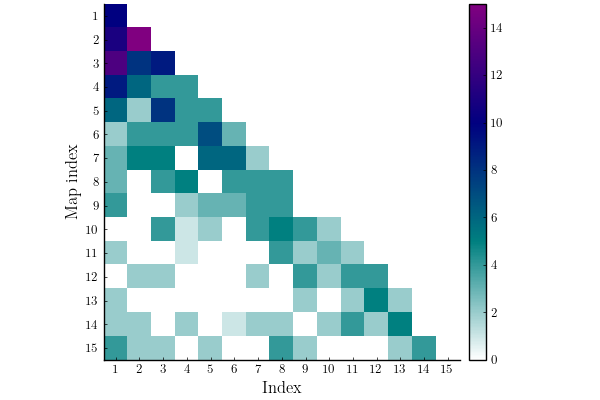

In [108]:
plot(S)
# savefig("Lorenz96_structure.pdf")

Baptista et al.[3] showed that the conditional independence properties of a random variable $\mathsf{X} \in \mathbb{R}^n$ with density $\pi$ are specified by the *Hessian score matrix* $\boldsymbol{\Omega} \in \mathbb{R}^{n \times n}$ defined as:

\begin{equation}
\Omega_{i,j} = \mathrm{E}_{\pi} \left[ |\partial_i\partial_j \log \pi(\boldsymbol{x})|^2  \right] = \int |\partial_i\partial_j \log \pi(\boldsymbol{x})|^2 \pi(\boldsymbol{x}) \; \mathrm{d}\boldsymbol{x}.
\end{equation}

The pullback density $\boldsymbol{S}^{\sharp} \rho$ can be used to approximate the true density $\pi$, where $\rho$ denotes the standard Gaussian distribution of $\mathbb{R}^n$. Thus, the score matrix is estimated by [3]: 
\begin{equation}
\hat{\Omega}_{i,j} = \mathrm{E}_{\pi} \left[ |\partial_i\partial_j \log \boldsymbol{S}^{\sharp} \rho|^2  \right]
\end{equation}

In practice, we use a sampled-based approximation of $\hat{\boldsymbol{\Omega}}$ using samples $\{\boldsymbol{x}^k\}, \; k=1,\ldots, N_e$ of $\pi$ [3]:


\begin{equation}
\hat{\Omega}_{i,j} \approx \sum_{k=1}^{N_e}|\partial_i\partial_j \log \boldsymbol{S}^{\sharp}\rho(\boldsymbol{x}^k )|^2
\end{equation}

The function `hess_x_log_pdf!` computes in-place the Hessian of the log pdf of the pullback density $\boldsymbol{S}^{\sharp} \rho$. You can also use `hess_x_log_pdf`.

In [109]:
Ωhat = zeros(Nx, Nx)
cache = zeros(1, Nx, Nx)
@showprogress for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


15×15 Array{Float64,2}:
     1.28264e6   1420.96       33496.2        …   4032.42        1022.19
  1420.96           6.66456e5    110.108           113.841       5176.8
 33496.2          110.108          8.52393e5         1.30498      807.432
   415.243      13616.1          201.11            152.532          0.0
    10.5442       664.078       6392.84              0.0650295     18.3906
   566.238        349.479       2973.37       …      0.589756       0.0
   205.818         72.8609         7.00461          20.3015         0.0
   587.927          2.53865       19.3259            0.627785      73.4162
     1.20837        0.0356291      7.21873           0.0699459     17.3412
     2.09817       38.7016         9.40222          37.1602         0.0
    86.9012        16.1491         0.452195   …    311.995          0.0
   431.818        161.389          6.67723        9512.23           0.0
    74.2171       436.71          71.818            23.0144      6221.09
  4032.42         113.841  

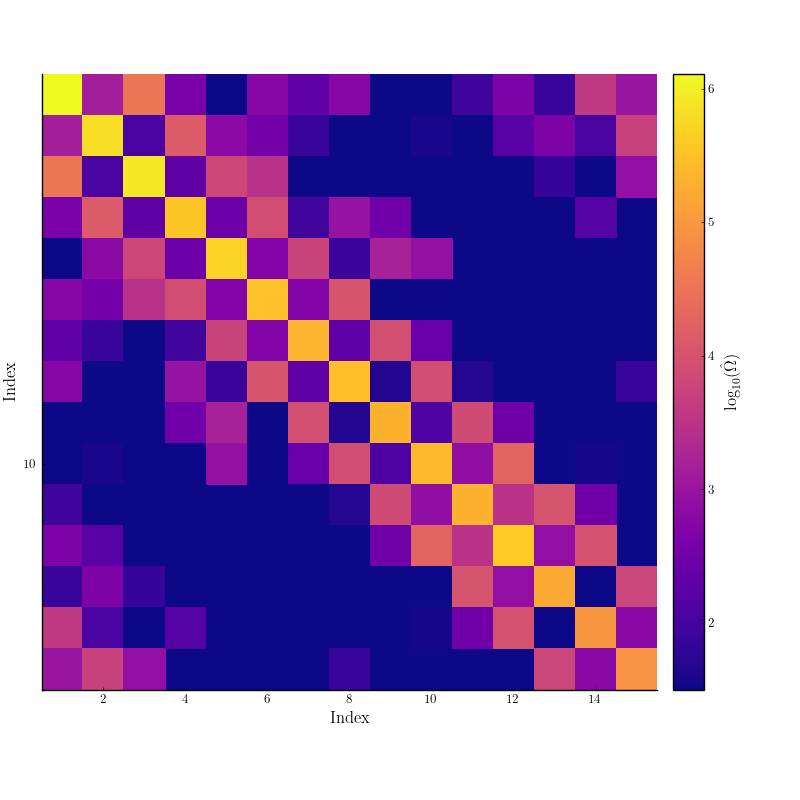

┌ Warning: /media/mat/HDD/AdaptiveTransportMap/src/dynamic is not an existing directory, Revise is not watching
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:565


In [110]:
plt = plot(size = (800, 800))

heatmap!(plt,log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (1.5, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt